In [2]:
from utils.libration_sense import *

orbit_type = 'L1'
orbit_num = 192

# матрица монодромии
M = get_monodromy_matrix(orbit_type, orbit_num)
print(np.linalg.eigvals(M))

# начальная точка для интегратора
x0, z0, vy0, T, _, __ = initial_state_parser(orbit_type, orbit_num)
initial_state_da = array.identity(6)
initial_state_da[0] += x0  # x
initial_state_da[2] += z0  # z
initial_state_da[4] += vy0  # v_y
initial_state_cons = initial_state_da.cons()  # положения и скорости центральной точки

# генерируем положения вокруг initial_state из нормального распределения с клиппингом
std_pos = km2du(8)  # 8 км
std_vel = kmS2vu(0.01e-3)  # 0.01 м/c
std_devs = np.array([std_pos] * 3 + [std_vel] * 3)
initial_deviations = np.random.normal(0, std_devs, (10000, 6))
limits = np.array([3 * std_pos] * 3 + [3 * std_vel] * 3)
initial_deviations = np.clip(initial_deviations, -limits, limits)

new_initial_states = initial_state_cons + initial_deviations  # отклонения от начального положения
print(type(new_initial_states))
print(initial_deviations.shape)
print(initial_deviations[0])

[-0.63095458+0.77581977j -0.63095458-0.77581977j  0.66197984+0.74952164j
  0.66197984-0.74952164j  0.99571192+0.j          1.00430654+0.j        ]
<class 'numpy.ndarray'>
(10000, 6)
[ 1.70710696e-05 -1.64115114e-05 -1.13451504e-05  1.75489148e-05
  9.18948480e-06 -2.64719202e-06]


In [3]:
# проверка "линейности"
from tqdm.notebook import tqdm

DA.init(3, 6)
xf = RK78(initial_state_da, 0.0, T, CR3BP)

residuals = []
for (new_initial_state, initial_deviation) in tqdm(zip(new_initial_states, initial_deviations), total=len(new_initial_states)):
    xf_nonlinear = xf.eval(initial_deviation)

    delta_x_T_integrate = xf_nonlinear - initial_state_cons

    delta_x_T_monodromy = M @ initial_deviation

    residuals.append(du2km(np.linalg.norm(delta_x_T_integrate - delta_x_T_monodromy)))

  0%|          | 0/10000 [00:00<?, ?it/s]

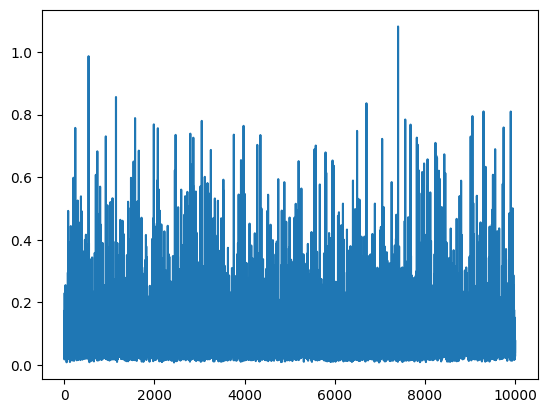

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(residuals)), residuals)

график по оси x порядок приближения конечных положений, по оси y ошибка в сравнении с интегрированием (медиана, максимум или еще что-то)

равномерное взять